# Geneset for Gold standard gene set for sepsis : DisGeNet & CTD

In [1]:
import pandas as pd
import numpy as np
import pickle, json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def score_category(score):
    if score is None:
        return None
    elif score >= 7:
        return 'High'
    elif score >= 4:
        return 'Medium'
    elif score <= 3:
        return 'Low'


def getgenWise_wt_score(df, score_cat):
    """
    Calculate weighted scores for genes based on their score categories.

    This function computes a weighted score for each gene by normalizing the 
    score categories ('High', 'Medium', 'Low') and applying predefined weights:
    - 'High' contributes 1.0
    - 'Medium' contributes 0.7
    - 'Low' contributes 0.3

    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing gene information and score categories.
    score_cat : str
        The column name in the DataFrame representing the score categories.

    Returns:
    --------
    pandas.Series
        A Series containing the weighted scores for each gene.
    """
    cat_score = pd.crosstab(df['gene_name'], df[score_cat], normalize=0)
    # multiply factors
    return cat_score.get('High', 0) * 1 + cat_score.get('Medium', 0) * 0.7 + cat_score.get('Low', 0) * 0.3

# Load Geneset data

In [3]:
refData = pd.read_csv("./externalRef/geneSet/gene_source_summary_external_5sources.csv",index_col=0)
print (f"Reference data loaded with shape: {refData.shape}")
# load gold standard details
# set gold standard preference to DisGeNet and CTD for their rig evalution
ref_dgn_ctd = refData[['DisGeNET', 'CTD']].dropna(how='all').reset_index()
print (ref_dgn_ctd.shape, refData.shape)


disgennet = pd.read_csv("./externalRef/geneSet/DisGENNET_DISEASES_Summary_GDA_CURATED.csv")
ctd_df = pd.read_csv("./externalRef/geneSet/CTD_D018805_genes_20250617233754.csv")
print (f"DisGeNet data loaded with shape: {disgennet.shape}")
print (f"CTD data loaded with shape: {ctd_df.shape}")

Reference data loaded with shape: (507, 6)
(52, 3) (507, 6)
DisGeNet data loaded with shape: (132, 34)
CTD data loaded with shape: (71889, 8)


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_8687/2783973271.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  ctd_df = pd.read_csv("./externalRef/geneSet/CTD_D018805_genes_20250617233754.csv")


In [8]:
# load pubmed counts
pubmed_df_ = pd.read_csv("./data/pubmed_gene_sepsis.csv")
print (len(set(pubmed_df_['Input Symbol'].values).intersection(set(ref_dgn_ctd.gene_symbol))), "genes in pubmed_df_ are in ref_dgn_ctd")
gene_not_found = set(ref_dgn_ctd.gene_symbol) - set(pubmed_df_['Input Symbol'].values)
print (f"Number of genes in ref_dgn_ctd not found in pubmed_df_: {len(gene_not_found)}, genes: {gene_not_found}")


50 genes in pubmed_df_ are in ref_dgn_ctd
Number of genes in ref_dgn_ctd not found in pubmed_df_: 2, genes: {'MT2', 'ABCB1B'}


# Load pipeline scored data

In [4]:
with open("data/goldStandard_rago4_phi4_gs.pkl", "rb") as f:
    gold_standard = pickle.load(f)
print(f"Gold standard loaded with shape: {gold_standard.shape}")
print (f"Genes investigated in gold standard: {gold_standard['gene_name'].nunique()}")

/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_8687/1986826100.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  gold_standard = pickle.load(f)


Gold standard loaded with shape: (416, 24)
Genes investigated in gold standard: 52


In [7]:
gold_standard.columns

Index(['final_answer', 'final_score', 'scientific_explanation', 'model',
       'json_key', 'gene_name', 'query', 'naive_score', 'naive_justification',
       'rag_score', 'rag_justification', 'rag_node_score', 'rag_noderetrived',
       'reference', 'RAG_Evaluation_Result', 'RAG_Reasoning', 'RAG_evalutator',
       'rag_usage.prompt_tokens', 'rag_usage.completion_tokens',
       'rag_usage.total_tokens', 'gene_qkey', 'naive_category', 'rag_category',
       'hybrid_category'],
      dtype='object')

In [27]:
pubmed_df__ss = pubmed_df_[pubmed_df_['Input Symbol'].isin(gold_standard.gene_name.unique())]
print (pubmed_df__ss.shape[0], "instances in pubmed_df_ are in RAG response", pubmed_df__ss['Input Symbol'].nunique(), "genes")

50 instances in pubmed_df_ are in RAG response 50 genes


In [36]:

# calculate gene wise weighted score
gs_genewise_scores = pd.DataFrame(index=gold_standard.gene_name.unique())
gs_genewise_scores['naive_wt_score'] = getgenWise_wt_score(gold_standard, 'naive_category')
# set only where evaluation has been passed
gs_genewise_scores['rag_wt_score'] = getgenWise_wt_score(gold_standard[gold_standard.RAG_Evaluation_Result=="Pass"], 'rag_category')
gs_genewise_scores['hybrid_wt_score'] = getgenWise_wt_score(gold_standard[gold_standard.RAG_Evaluation_Result=="Pass"], 'hybrid_category')
# Ensure the index is unique before reindexing
pubmed_df_unique = pubmed_df_.drop_duplicates(subset='Input Symbol').set_index('Input Symbol')
gs_genewise_scores['pubmed_count'] = pubmed_df__ss.set_index("Input Symbol")[['count']]
# add population level scores
gs_genewise_scores['pub_log'] = np.log10(gs_genewise_scores['pubmed_count'] + 1)  # log transform to reduce skewness
# min-max normalize the pub_log
gs_genewise_scores['popularity'] = (gs_genewise_scores['pub_log'] - gs_genewise_scores['pub_log'].min()) / (gs_genewise_scores['pub_log'].max() - gs_genewise_scores['pub_log'].min())


# Figure 1A : Naive score w.r.t gold standard normalized scores

In [37]:
naive_result = gold_standard[['gene_name','json_key','naive_score']].copy()
print (f"GS naive shape: {naive_result.shape}")

naive_result['naive_state'] = np.where(naive_result.naive_score<= 5, 'fail', 'pass')
naive_Score_state = pd.crosstab(naive_result.gene_name, naive_result['naive_state'])
naive_Score_state_pass = naive_Score_state[naive_Score_state["pass"]>=1].sort_values(by="pass", ascending=False)

print (naive_Score_state_pass.shape[0], "genes pass the naive threshold")
print (naive_Score_state_pass.shape[0]/naive_result.gene_name.nunique(), "genes pass the naive threshold out of", naive_result.gene_name.nunique())

GS naive shape: (416, 3)
37 genes pass the naive threshold
0.7115384615384616 genes pass the naive threshold out of 52


In [38]:
naive_Score_state_gs = naive_Score_state.loc[ref_dgn_ctd.gene_symbol]
# make a columns with naive status pass with pass >=1
naive_Score_state_gs['naive_status'] = np.where(naive_Score_state_gs['pass']>=1, 'pass', 'fail')

In [39]:
naive_Score_state_gs.sort_values(by='pass', ascending=False, inplace=True)
gs_genewise_scores = naive_Score_state_gs.join(gs_genewise_scores)
gs_genewise_scores.head()

,fail,pass,naive_status,naive_wt_score,rag_wt_score,hybrid_wt_score,pubmed_count,pub_log,popularity
gene_name,,,,,,,,,
MIF,0,8,pass,1.0000,0.9250,0.9250,160.0,2.206826,0.567100
PROC,0,8,pass,0.9625,1.0000,1.0000,9.0,1.000000,0.256975
ADM,0,8,pass,0.9250,0.9000,1.0000,174.0,2.243038,0.576405
C5AR1,0,8,pass,0.9625,0.9625,0.9625,19.0,1.301030,0.334332
IL6,0,8,pass,1.0000,0.9400,0.9400,5930.0,3.773128,0.969600


In [40]:
gs_genewise_scores.groupby("naive_status").size()

naive_status
fail    15
pass    37
dtype: int64

In [54]:

ctd_df_filtered = ctd_df[ctd_df['Gene Symbol'].isin(gs_genewise_scores.index)].drop_duplicates(subset=['Gene Symbol']).set_index("Gene Symbol")
disgennet_filter = disgennet[['Gene','ScoreGDA']].set_index("Gene")
disgennet_filter = disgennet_filter.reset_index().drop_duplicates(subset=['Gene']).set_index("Gene")

print (ctd_df_filtered.shape, disgennet_filter.shape)

# make one reference dataframe
detail_ref = pd.concat([ctd_df_filtered, disgennet_filter], axis=1, join='outer')
detail_ref = detail_ref.reset_index().rename(columns={"index": "gene_symbol"})
# normalize scores
detail_ref['ctd_normscore'] = (detail_ref['Inference Score'] - detail_ref['Inference Score'].min()) / (detail_ref['Inference Score'].max() - detail_ref['Inference Score'].min())
detail_ref['ScoreGDA_norm'] = (detail_ref['ScoreGDA'] - detail_ref['ScoreGDA'].min()) / (detail_ref['ScoreGDA'].max() - detail_ref['ScoreGDA'].min()) 
detail_ref.set_index('gene_symbol', inplace=True)
# merge  gs_genewise_scores and detail_ref
gs_genewise_scores = gs_genewise_scores.merge(detail_ref, how='left', left_index=True, right_index=True)
gs_genewise_scores.sort_values(by='naive_wt_score', ascending=False, inplace=True)

(52, 7) (32, 1)


In [55]:
gs_genewise_scores.head()

,fail,pass,naive_status,naive_wt_score,rag_wt_score,hybrid_wt_score,pubmed_count,pub_log,popularity,Gene ID_x,...,Gene ID,Disease Name,Disease ID,Direct Evidence,Inference Network,Inference Score,Reference Count,ScoreGDA,ctd_normscore,ScoreGDA_norm
gene_name,,,,,,,,,,,,,,,,,,,,,
TNF,0,8,pass,1.0,0.814286,0.814286,7787.0,3.891426,1.000000,7124,...,7124,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",158.36,117,1.00,0.971318,1.000000
IL10,0,8,pass,1.0,0.914286,0.914286,2706.0,3.432488,0.882064,3586,...,3586,Sepsis,MESH:D018805,therapeutic,"alisol B 23-acetate|apigenin-6,8-di-C-glycopyr...",116.59,91,1.00,0.711442,1.000000
HMGB1,0,8,pass,1.0,0.914286,0.914286,741.0,2.870404,0.737623,3146,...,3146,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",90.31,75,0.95,0.547938,0.916667
TREM1,0,8,pass,1.0,1.000000,1.000000,191.0,2.283301,0.586752,54210,...,54210,Endotoxemia,MESH:D019446,NaN,diallyl disulfide|Lipopolysaccharides|Nicotine...,15.05,27,0.90,0.079699,0.833333
IL6,0,8,pass,1.0,0.940000,0.940000,5930.0,3.773128,0.969600,3569,...,3569,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",160.71,105,1.00,0.985939,1.000000


/var/folders/t3/68lkvp7d7dlcctl6w91ml6yj8cs2fb/T/ipykernel_8687/3565142414.py:15: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(data=gs_genewise_scores_fig1, x='source', y='normalized_score', hue="naive_status", color="k", dodge=True, alpha=0.5, jitter=True, legend=False)


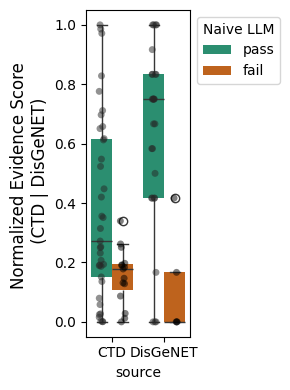

In [43]:
gs_genewise_scores_fig1 = gs_genewise_scores[['naive_status','ctd_normscore','ScoreGDA_norm']].reset_index().melt(
    id_vars=['gene_name','naive_status'],
    value_vars=['ctd_normscore','ScoreGDA_norm'],
    var_name='source',
    value_name='normalized_score'
)

gs_genewise_scores_fig1['source'] = gs_genewise_scores_fig1['source'].map({'ctd_normscore':'CTD', 'ScoreGDA_norm': 'DisGeNET'})
# Plotting the results

status_colors = {'pass': '#1b9e77', 'fail': '#d95f02'} # teal /orange
plt.figure(figsize=(3, 4))
sns.boxplot(data=gs_genewise_scores_fig1, x='source', y='normalized_score', hue="naive_status", palette=status_colors, \
    showfliers=True, boxprops=dict(edgecolor='none'))
sns.stripplot(data=gs_genewise_scores_fig1, x='source', y='normalized_score', hue="naive_status", color="k", dodge=True, alpha=0.5, jitter=True, legend=False)
plt.legend(title='Naive LLM', loc='upper left', bbox_to_anchor=(1, 1))
plt.ylabel("Normalized Evidence Score \n (CTD | DisGeNET)", fontdict={'size': 12})
plt.tight_layout()
# plt.savefig("./output/Figures/fig1A_geneEvidenceScores.pdf", bbox_inches='tight', dpi=300)
plt.show()

# Figure 1B : scoring pattern comparision across

In [44]:
gs_genewise_scores.sort_values(by='popularity', ascending=False, inplace=True)

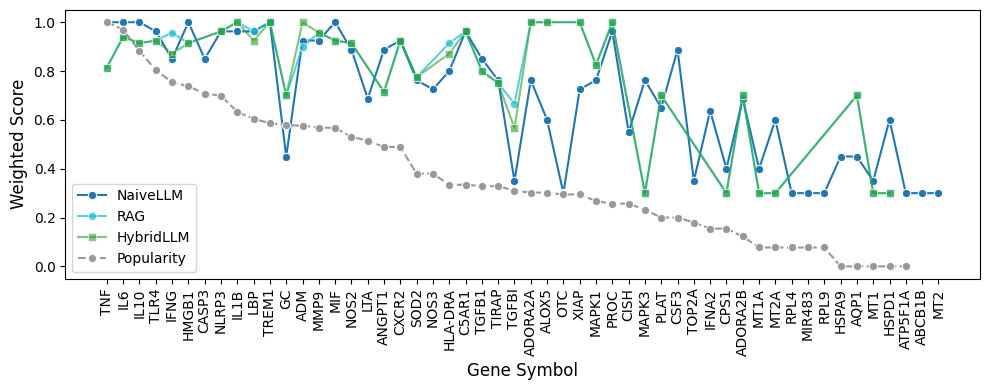

In [45]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=gs_genewise_scores, x=gs_genewise_scores.index, y='naive_wt_score', label='NaiveLLM', marker='o', color="#1f77b4")
sns.lineplot(data=gs_genewise_scores, x=gs_genewise_scores.index, y='rag_wt_score', label='RAG', marker='o', color='#17becf', alpha=0.7)
sns.lineplot(data=gs_genewise_scores, x=gs_genewise_scores.index, y='hybrid_wt_score', label='HybridLLM', marker='s',color="#2ca02c",alpha=0.6)
sns.lineplot(data=gs_genewise_scores, x=gs_genewise_scores.index, y='popularity', label='Popularity', marker='o', color='#999999', linestyle='--')
# plt.title('Weighted Scores Comparison')
plt.xlabel('Gene Symbol', fontdict={'fontsize': 12})
plt.ylabel('Weighted Score',fontdict={'fontsize': 12})
plt.xticks(rotation=90)
plt.legend(loc='lower left')  # Adjust legend position and columns
plt.tight_layout()
# plt.savefig("./output/Figures/Fig1_weighted_scores_comparison_gpt4o.pdf", dpi=300)
plt.show()

# Table S1 : Spearmann correlation

In [47]:
!pip install scipy --quiet

In [49]:
detail_ref.head()

,Gene ID,Disease Name,Disease ID,Direct Evidence,Inference Network,Inference Score,Reference Count,ScoreGDA,ctd_normscore,ScoreGDA_norm
gene_symbol,,,,,,,,,,
IL1B,3553,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",162.97,111,1.00,1.000000,1.000000
IL6,3569,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",160.71,105,1.00,0.985939,1.000000
TNF,7124,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",158.36,117,1.00,0.971318,1.000000
NOS2,4843,Sepsis,MESH:D018805,marker/mechanism,"2',4'-dihydroxy-6'-methoxy-3',5'-dimethylchalc...",135.36,94,0.80,0.828221,0.666667
CASP3,836,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",126.99,106,0.65,0.776146,0.416667


In [48]:
# calculate spearmann correlation between naive, rag and hybrid scores, popularity
from scipy.stats import spearmanr

In [56]:
gs_genewise_scores.head()

,fail,pass,naive_status,naive_wt_score,rag_wt_score,hybrid_wt_score,pubmed_count,pub_log,popularity,Gene ID_x,...,Gene ID,Disease Name,Disease ID,Direct Evidence,Inference Network,Inference Score,Reference Count,ScoreGDA,ctd_normscore,ScoreGDA_norm
gene_name,,,,,,,,,,,,,,,,,,,,,
TNF,0,8,pass,1.0,0.814286,0.814286,7787.0,3.891426,1.000000,7124,...,7124,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",158.36,117,1.00,0.971318,1.000000
IL10,0,8,pass,1.0,0.914286,0.914286,2706.0,3.432488,0.882064,3586,...,3586,Sepsis,MESH:D018805,therapeutic,"alisol B 23-acetate|apigenin-6,8-di-C-glycopyr...",116.59,91,1.00,0.711442,1.000000
HMGB1,0,8,pass,1.0,0.914286,0.914286,741.0,2.870404,0.737623,3146,...,3146,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",90.31,75,0.95,0.547938,0.916667
TREM1,0,8,pass,1.0,1.000000,1.000000,191.0,2.283301,0.586752,54210,...,54210,Endotoxemia,MESH:D019446,NaN,diallyl disulfide|Lipopolysaccharides|Nicotine...,15.05,27,0.90,0.079699,0.833333
IL6,0,8,pass,1.0,0.940000,0.940000,5930.0,3.773128,0.969600,3569,...,3569,Sepsis,MESH:D018805,marker/mechanism,"1-(3,4-dihydroxyphenyl)-3-(2-methoxyphenyl)pro...",160.71,105,1.00,0.985939,1.000000


In [57]:
# pairwise correlation
correlation_results = {}
cols_fto_focus = ['naive_wt_score', 'rag_wt_score', 'hybrid_wt_score', 'popularity','ctd_normscore','ScoreGDA_norm']
for col1 in cols_fto_focus:
    for col2 in cols_fto_focus:
        if col1 != col2:
            corr, p_value = spearmanr(gs_genewise_scores[col1], gs_genewise_scores[col2], nan_policy='omit')
            correlation_results[(col1, col2)] = (corr, p_value)
            
#make a dataframe
correlation_df = pd.DataFrame(correlation_results, index=['Spearman Correlation', 'p-value']).T
correlation_df.columns = ['Spearman Correlation', 'p-value']
correlation_df = correlation_df.sort_values(by='Spearman Correlation', ascending=False)
correlation_dfX = correlation_df.reset_index().sort_values(by=['level_0', 'level_1'])

# Figure 1C: agreement among topK genes 

In [58]:
def topk_overlap(df, llm_col, disgenet_col, k_list=[5, 10, 20]):
    results = []
    for k in k_list:
        top_llm = set(df.nlargest(k, llm_col).index)
        top_disgenet = set(df.nlargest(k, disgenet_col).index)
        overlap = len(top_llm & top_disgenet)
        jaccard = overlap / len(top_llm | top_disgenet)

        results.append({
            'K': k,
            'Overlap Count': overlap,
            'Overlap (%)': overlap / k * 100,
            'Jaccard': jaccard
        })
    return pd.DataFrame(results)


In [59]:
llm_scores_cols = ['naive_wt_score', 'rag_wt_score', 'hybrid_wt_score']
db_scores_cols = ['ctd_normscore', 'ScoreGDA_norm']
db_col_map = {
    'ctd_normscore': 'CTD',
    'ScoreGDA_norm': 'DisGeNET'}
k_list = [5, 10, 15, 20, 25, 30]
top_k_matrix = pd.DataFrame()

for llm_col in llm_scores_cols:
    for db_col in db_scores_cols:
        # print(f"Top K overlap between {llm_col} and {db_col}:")
        overlap_df = topk_overlap(gs_genewise_scores, llm_col, db_col, k_list=k_list)
        # add results to top_k_matrix
        overlap_df['LLM Score'] = llm_col
        overlap_df['DB Score'] = db_col_map[db_col]
        top_k_matrix = pd.concat([top_k_matrix, overlap_df], ignore_index=True)
        # print("\n")

top_k_matrix["LLM Score"]  = top_k_matrix["LLM Score"].str.replace("_wt_score", "")
top_k_matrix["DB Score"] = top_k_matrix["DB Score"].str.replace("_normscore_y", "")
top_k_matrix = top_k_matrix.rename(columns={"LLM Score": "LLM", "DB Score": "Database"})
top_k_matrix['LLM'] = top_k_matrix['LLM'].map({'naive':'NaiveLLM', 'rag':'RAG', 'hybrid':'HybridLLM'})
# "#1f77b4",'#17becf',"#2ca02c"
llm_score_colors ={'NaiveLLM':"#1f77b4", 'RAG':"#17becf", 'HybridLLM':"#2ca02c"}
top_k_matrix.head()

,K,Overlap Count,Overlap (%),Jaccard,LLM,Database
0,5,2,40.000000,0.250000,NaiveLLM,CTD
1,10,4,40.000000,0.250000,NaiveLLM,CTD
2,15,8,53.333333,0.363636,NaiveLLM,CTD
3,20,12,60.000000,0.428571,NaiveLLM,CTD
4,25,16,64.000000,0.470588,NaiveLLM,CTD


## pct Overlap plot [mainfigure]

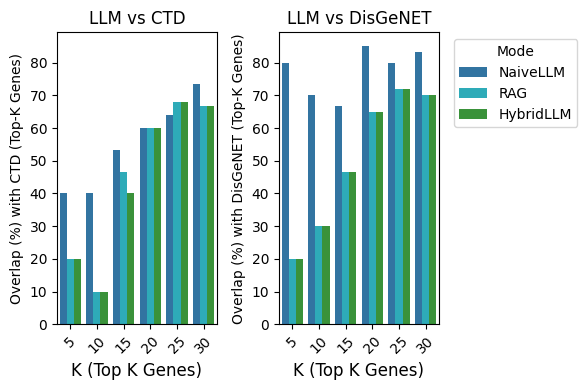

In [60]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Plot for CTD
sns.barplot(data=top_k_matrix[top_k_matrix['Database'] == "CTD"], x='K', y='Overlap (%)', hue='LLM', \
    palette=llm_score_colors, ax=axes[0])
axes[0].set_title('LLM vs CTD')
axes[0].set_xlabel('K (Top K Genes)', fontdict={'fontsize': 12})
axes[0].set_ylabel('Overlap (%) with CTD (Top-K Genes)', fontdict={'fontsize': 10})
axes[0].legend(title='LLM Score', loc='upper left')
axes[0].tick_params(axis='x', rotation=45)
axes[0].get_legend().remove()

# # Add faint dotted lines for CTD
# for llm in top_k_matrix[top_k_matrix['Database'] == "ctd"]['LLM'].unique():
#     subset = top_k_matrix[(top_k_matrix['Database'] == "ctd") & (top_k_matrix['LLM'] == llm)]
#     axes[0].plot(subset['K'], subset['Jaccard'], linestyle='dotted', alpha=0.5, color=llm_score_colors[llm])

# Plot for DisGeNET
sns.barplot(data=top_k_matrix[top_k_matrix['Database'] == "DisGeNET"], x='K', y='Overlap (%)', hue='LLM',\
     palette=llm_score_colors, ax=axes[1])
axes[1].set_title('LLM vs DisGeNET')
axes[1].set_xlabel('K (Top K Genes)', fontdict={'fontsize': 12})
axes[1].set_ylabel('Overlap (%) with DisGeNET (Top-K Genes)', fontdict={'fontsize': 10})
axes[1].legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45)

# # Add faint dotted lines for DisGeNET
# for llm in top_k_matrix[top_k_matrix['Database'] == "ScoreGDA_norm_y"]['LLM'].unique():
#     subset = top_k_matrix[(top_k_matrix['Database'] == "ScoreGDA_norm_y") & (top_k_matrix['LLM'] == llm)]
#     axes[1].plot(subset['K'], subset['Jaccard'], linestyle='dotted', alpha=0.5, color=llm_score_colors[llm])

# Set the same y-axis limits for both plots
y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.tight_layout()
# plt.savefig("./output/Figures/Fig1C_TopK_Jaccard_Similarity_fig1D_pctoverlap.pdf", dpi=300)
plt.show()


## jaccard score [additional figure]

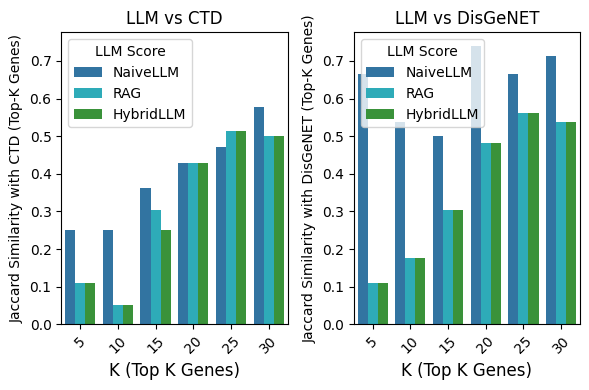

In [61]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Plot for CTD
sns.barplot(data=top_k_matrix[top_k_matrix['Database'] == "CTD"], x='K', y='Jaccard', hue='LLM', palette=llm_score_colors,  ax=axes[0])
axes[0].set_title('LLM vs CTD')
axes[0].set_xlabel('K (Top K Genes)', fontdict={'fontsize': 12})
axes[0].set_ylabel('Jaccard Similarity with CTD (Top-K Genes)', fontdict={'fontsize': 10})
axes[0].legend(title='LLM Score', loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# # Add faint dotted lines for CTD
# for llm in top_k_matrix[top_k_matrix['Database'] == "ctd"]['LLM'].unique():
#     subset = top_k_matrix[(top_k_matrix['Database'] == "ctd") & (top_k_matrix['LLM'] == llm)]
#     axes[0].plot(subset['K'], subset['Jaccard'], linestyle='dotted', alpha=0.5, color=llm_score_colors[llm])

# Plot for DisGeNET
sns.barplot(data=top_k_matrix[top_k_matrix['Database'] == "DisGeNET"], x='K', y='Jaccard', hue='LLM', palette=llm_score_colors, ax=axes[1])
axes[1].set_title('LLM vs DisGeNET')
axes[1].set_xlabel('K (Top K Genes)', fontdict={'fontsize': 12})
axes[1].set_ylabel('Jaccard Similarity with DisGeNET (Top-K Genes)', fontdict={'fontsize': 10})
axes[1].legend(title='LLM Score', loc='upper left')
axes[1].tick_params(axis='x', rotation=45)

# # Add faint dotted lines for DisGeNET
# for llm in top_k_matrix[top_k_matrix['Database'] == "ScoreGDA_norm_y"]['LLM'].unique():
#     subset = top_k_matrix[(top_k_matrix['Database'] == "ScoreGDA_norm_y") & (top_k_matrix['LLM'] == llm)]
#     axes[1].plot(subset['K'], subset['Jaccard'], linestyle='dotted', alpha=0.5, color=llm_score_colors[llm])

# Set the same y-axis limits for both plots
y_min = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(y_min, y_max)
axes[1].set_ylim(y_min, y_max)

plt.tight_layout()
# plt.savefig("./output/Figures/Fig_1C_supp_TopK_Jaccard_Similarity.pdf", dpi=300)
plt.show()

# Save checkpoint data

In [62]:
# gs_genewise_scores.to_csv("./output/data/goldStandard_genewise_scores.csv")
# rago4_phi4_gs.to_pickle("./output/data/goldStandard_rago4_phi4_gs.pkl")